In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.figsize'] = (20, 5)

In [2]:
def get_rms(data, n):
    new = np.zeros(data.shape)
    for channel in range(data.shape[1]):
        for current in range(data.shape[0]):
            suma = 0
            for window in range(current, current - n, -1):
                suma += data[window, channel] * data[window, channel]
            new[current, channel] = (np.sqrt((1/n)*suma) / 128) if channel != 8 else data[current, channel]
    #plt.figure()
    #plt.plot(data)
    #plt.figure()
    #plt.plot(new)
    return new

def peel_labels(data):
    return data[:,:8], data[:,8]

def get_values(seshes, skip_hibernation):
    big_matrix = np.zeros((0, 9))
    for sesh in seshes:
        for gesture in range(8):
            wei = sesh + "/" + str(gesture) + ".txt"
            print(wei)
            matrix = np.genfromtxt(wei, delimiter=",")
            rms = get_rms(matrix, 80)
            #plt.figure()
            #plt.plot(rms)
            if skip_hibernation:
                rms = rms[rms[:,8] != 0]
                rms[:,8] -= 1
            #plt.figure()
            #plt.plot(rms)
            big_matrix = np.concatenate((big_matrix, rms), axis = 0)
    return big_matrix

In [3]:
'''
#gotta go fast
skip_hibernation = True
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
print(*seshes, sep = "\n")
print("kekw")

start = 63

train_set, valid_set, test_set = get_values([seshes[start]], skip_hibernation), \
                                 get_values([seshes[start + 1]], skip_hibernation), \
                                 get_values([seshes[start + 2]], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)
'''

'\n#gotta go fast\nskip_hibernation = True\nreadings = "../myo-readings-dataset/_readings/"\nseshes = [x[0] for x in os.walk(readings)][1:]\nprint(*seshes, sep = "\n")\nprint("kekw")\n\nstart = 63\n\ntrain_set, valid_set, test_set = get_values([seshes[start]], skip_hibernation),                                  get_values([seshes[start + 1]], skip_hibernation),                                  get_values([seshes[start + 2]], skip_hibernation)\n\ntrain, train_labels = peel_labels(train_set)\nvalid, valid_labels = peel_labels(valid_set)\ntest, test_labels = peel_labels(test_set)\n'

In [4]:
#selected sessions
selection = [22, 23, 24, 25, 26, 27, 28, 29, 30]
skip_hibernation = True
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
seshes = [seshes[i] for i in selection]
np.random.shuffle(seshes)
print(*seshes, sep = "\n")
print("kekw")

siz = len(seshes)
split1 = int(0.6 * siz)
split2 = int(0.8 * siz)

train_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation), \
                                 get_values(seshes[split1:split2], skip_hibernation), \
                                 get_values(seshes[split2:], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)

../myo-readings-dataset/_readings/Seja 2
../myo-readings-dataset/_readings/Seja 1
../myo-readings-dataset/_readings/Seja 01
../myo-readings-dataset/_readings/Seja 03
../myo-readings-dataset/_readings/seja-3
../myo-readings-dataset/_readings/Seja 02
../myo-readings-dataset/_readings/Seja 3
../myo-readings-dataset/_readings/seja-2
../myo-readings-dataset/_readings/seja-1
kekw
../myo-readings-dataset/_readings/Seja 2/0.txt
../myo-readings-dataset/_readings/Seja 2/1.txt
../myo-readings-dataset/_readings/Seja 2/2.txt
../myo-readings-dataset/_readings/Seja 2/3.txt
../myo-readings-dataset/_readings/Seja 2/4.txt
../myo-readings-dataset/_readings/Seja 2/5.txt
../myo-readings-dataset/_readings/Seja 2/6.txt
../myo-readings-dataset/_readings/Seja 2/7.txt
../myo-readings-dataset/_readings/Seja 1/0.txt
../myo-readings-dataset/_readings/Seja 1/1.txt
../myo-readings-dataset/_readings/Seja 1/2.txt
../myo-readings-dataset/_readings/Seja 1/3.txt
../myo-readings-dataset/_readings/Seja 1/4.txt
../myo-readi

In [5]:
'''
#all sessions
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = list(os.walk(readings))[1:]
np.random.shuffle(seshes)
siz = len(seshes)
split1 = int(0.6 * siz)
split2 = int(0.8 * siz)
train_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation), \
                                 get_values(seshes[split1:split2], skip_hibernation), \
                                 get_values(seshes[split2:], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)
'''

'\n#all sessions\nskip_hibernation = False\nreadings = "../myo-readings-dataset/_readings/"\nseshes = list(os.walk(readings))[1:]\nnp.random.shuffle(seshes)\nsiz = len(seshes)\nsplit1 = int(0.6 * siz)\nsplit2 = int(0.8 * siz)\ntrain_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation),                                  get_values(seshes[split1:split2], skip_hibernation),                                  get_values(seshes[split2:], skip_hibernation)\n\ntrain, train_labels = peel_labels(train_set)\nvalid, valid_labels = peel_labels(valid_set)\ntest, test_labels = peel_labels(test_set)\n'

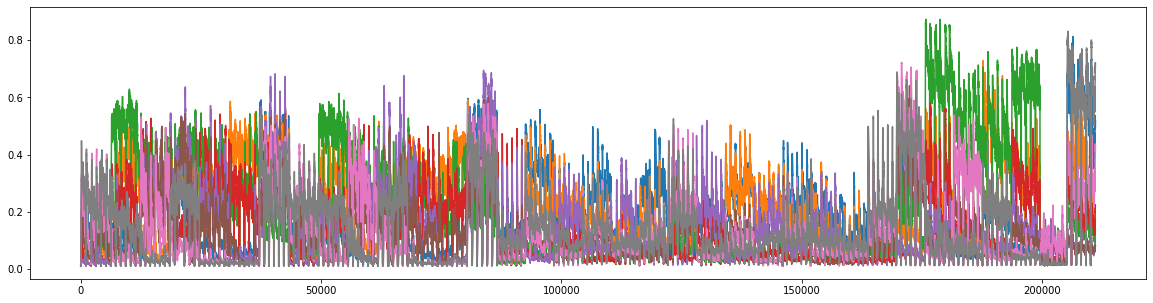

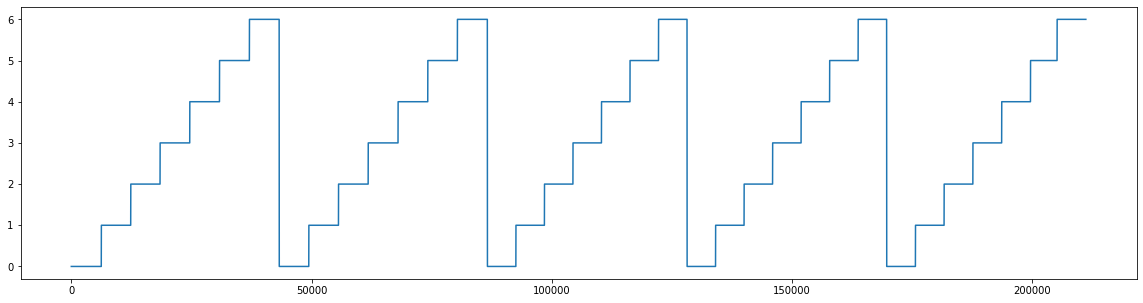

In [29]:
plt.figure()
plt.plot(train)
plt.figure()
plt.plot(train_labels)

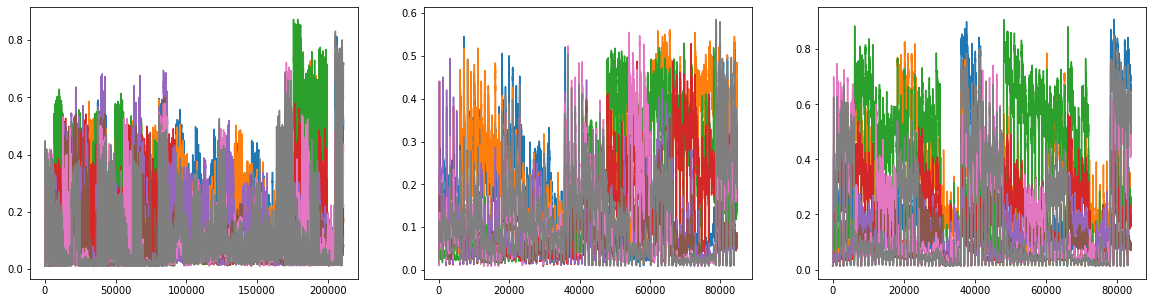

In [30]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(train)
ax[1].plot(valid)
ax[2].plot(test)

In [31]:
model = keras.Sequential([
    keras.layers.Dense(200, activation = "relu", input_shape = (8,)),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(70, activation = "relu"),
    keras.layers.Dense(7 if skip_hibernation else 8, activation = "sigmoid")
])

opt = keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])

In [32]:
history = model.fit(train, train_labels, validation_data = (valid, valid_labels), epochs=10)

Epoch 1/10
6599/6599 [==============================] - 10s 1ms/step - loss: 0.4671 - accuracy: 0.8373 - val_loss: 0.6609 - val_accuracy: 0.8178
Epoch 2/10
6599/6599 [==============================] - 7s 1ms/step - loss: 0.1591 - accuracy: 0.9424 - val_loss: 0.9383 - val_accuracy: 0.7581
Epoch 3/10
6599/6599 [==============================] - 6s 980us/step - loss: 0.1246 - accuracy: 0.9547 - val_loss: 0.7368 - val_accuracy: 0.8187
Epoch 4/10
6599/6599 [==============================] - 7s 997us/step - loss: 0.1050 - accuracy: 0.9621 - val_loss: 0.8010 - val_accuracy: 0.8186
Epoch 5/10
6599/6599 [==============================] - 7s 991us/step - loss: 0.0922 - accuracy: 0.9668 - val_loss: 0.9184 - val_accuracy: 0.7896
Epoch 6/10
6599/6599 [==============================] - 7s 1ms/step - loss: 0.0841 - accuracy: 0.9694 - val_loss: 0.7553 - val_accuracy: 0.8352
Epoch 7/10
6599/6599 [==============================] - 7s 1ms/step - loss: 0.0747 - accuracy: 0.9730 - val_loss: 0.8463 - val_ac

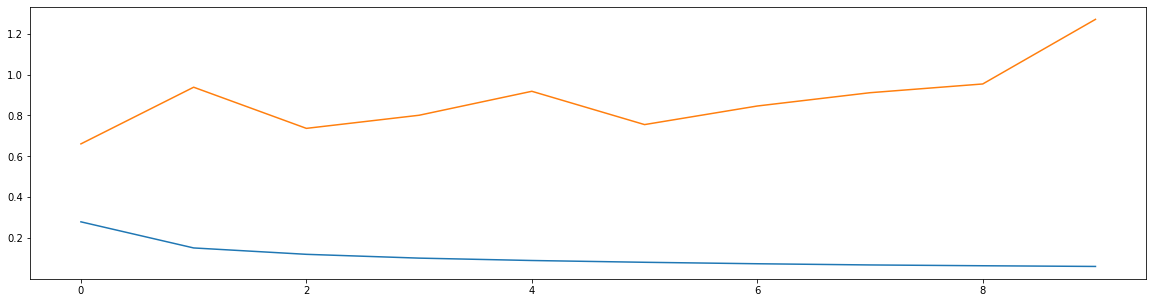

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

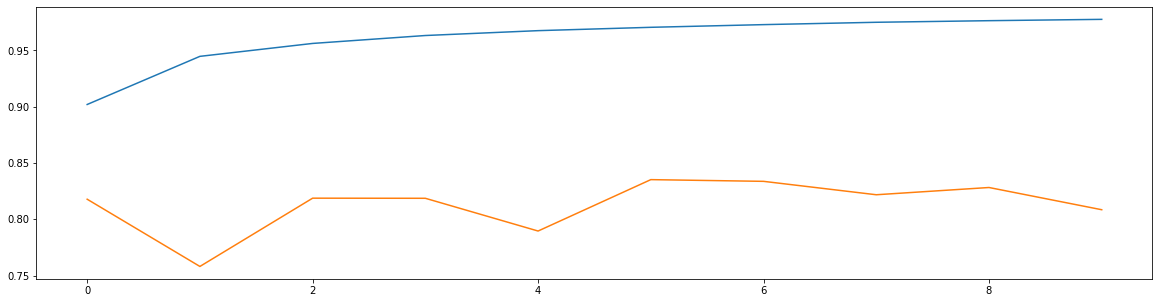

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [35]:
model.evaluate(test, test_labels)

2622/2622 [==============================] - 1s 519us/step - loss: 1.4074 - accuracy: 0.80190s - loss: 0.9849 - accuracy


[1.4074183702468872, 0.8018502593040466]

In [36]:
predictions = model.predict(test)

In [37]:
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(test_labels, predicted_labels)
conf

array([[11343,    33,    75,   176,   201,   110,    47],
       [   80, 10269,    38,   111,  1039,   432,    15],
       [  908,   341, 10126,    52,   228,   334,     3],
       [   13,  1610,    80,  9730,   197,   323,    14],
       [   82,   580,   184,   329, 10351,   442,    18],
       [   42,   525,  3380,   719,  5158,  2064,    93],
       [  115,  1115,    39,    27,   101,    40, 10549]], dtype=int64)

In [38]:
if skip_hibernation:
    legend = ["flexion", "extension", "radial deviation", "ulnar deviation", "pronation", "supination", "fist"]
else:
    legend = ["hibernation", "flexion", "extension", "radial deviation", "ulnar deviation", "pronation", "supination", "fist"]

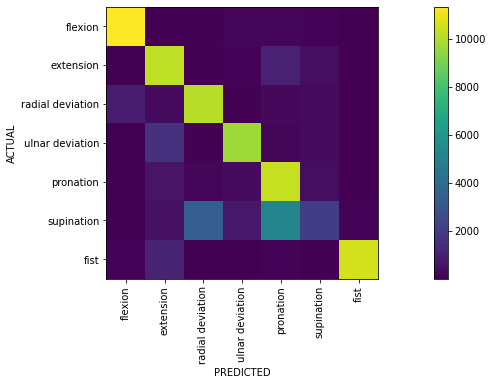

In [39]:
plt.imshow(conf)
plt.ylabel("ACTUAL")
plt.xlabel("PREDICTED")
plt.yticks(np.arange(len(legend)), legend)
plt.xticks(np.arange(len(legend)), legend, rotation='vertical')
plt.colorbar()

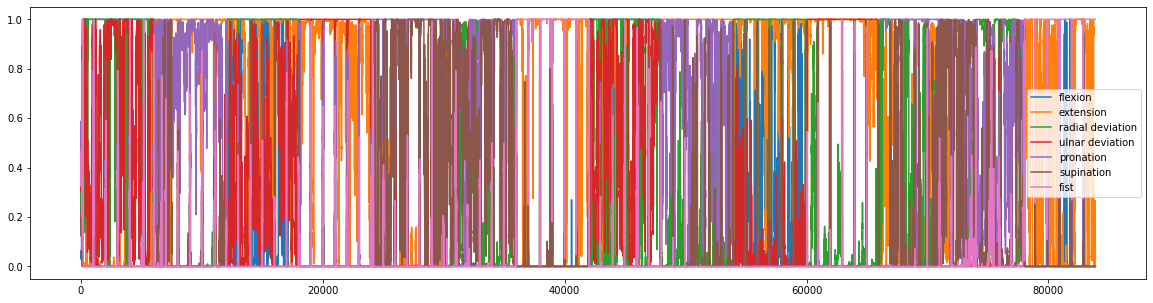

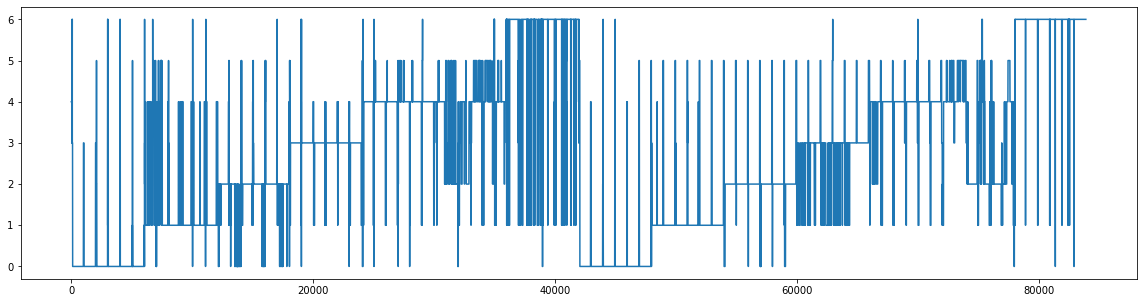

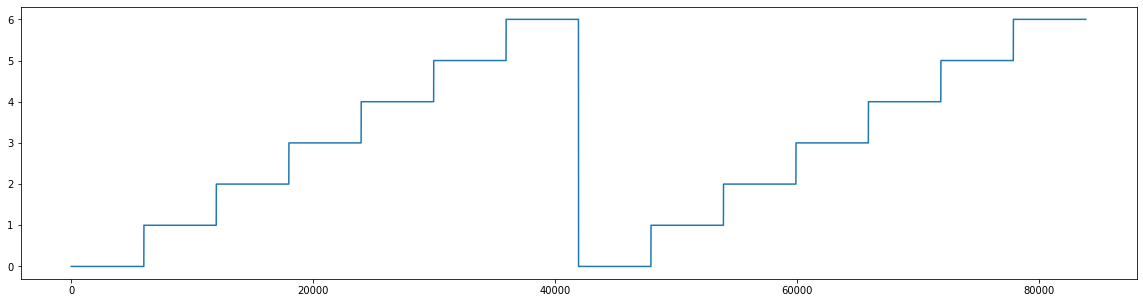

In [40]:
plt.figure()
plt.plot(predictions)
plt.legend(legend)
plt.figure()
plt.plot(predicted_labels)
plt.figure()
plt.plot(test_labels)

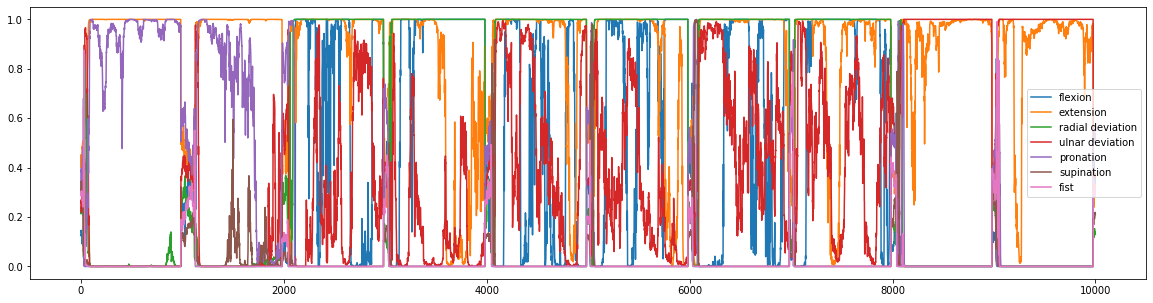

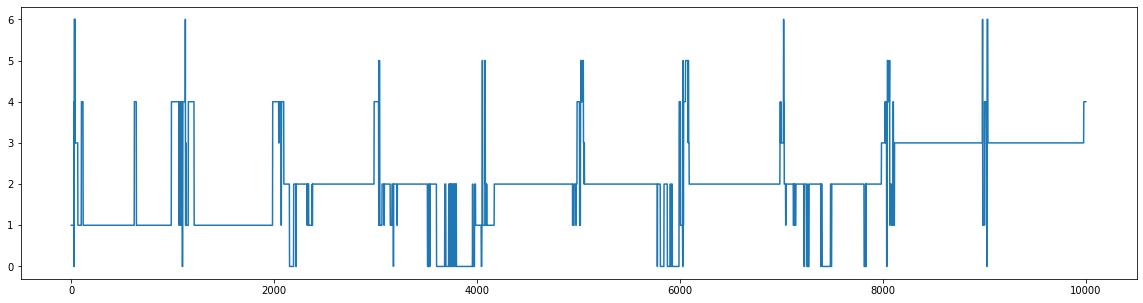

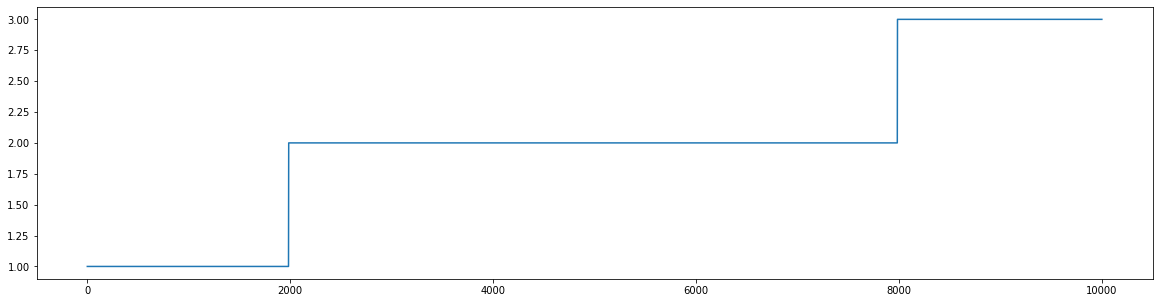

In [41]:
plt.figure()
plt.plot(predictions[10000:20000])
plt.legend(legend)
plt.figure()
plt.plot(predicted_labels[10000:20000])
plt.figure()
plt.plot(test_labels[10000:20000])

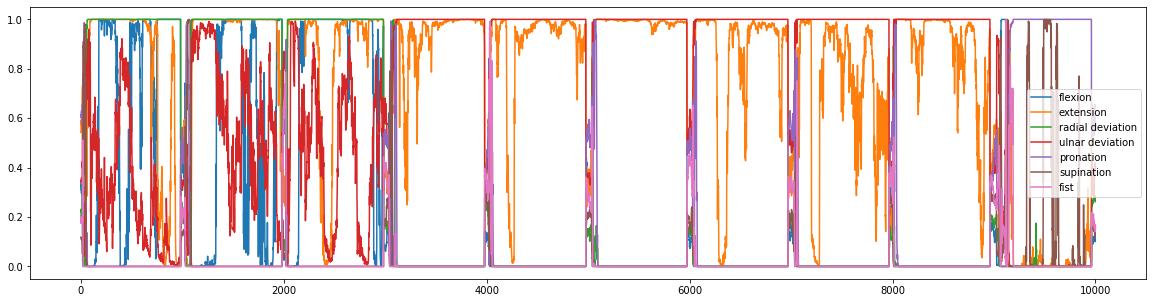

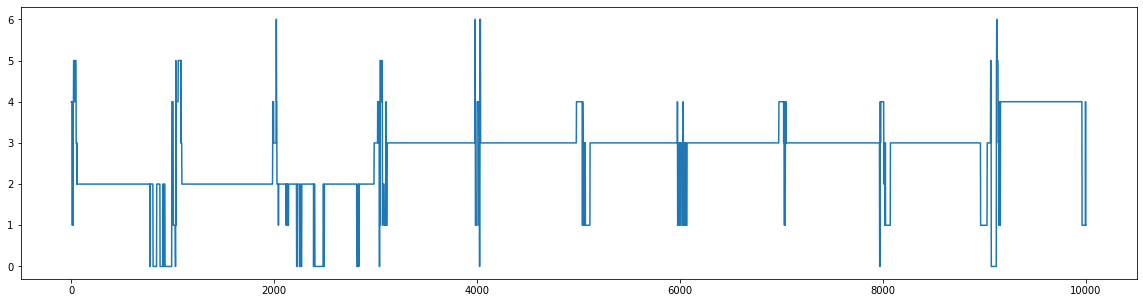

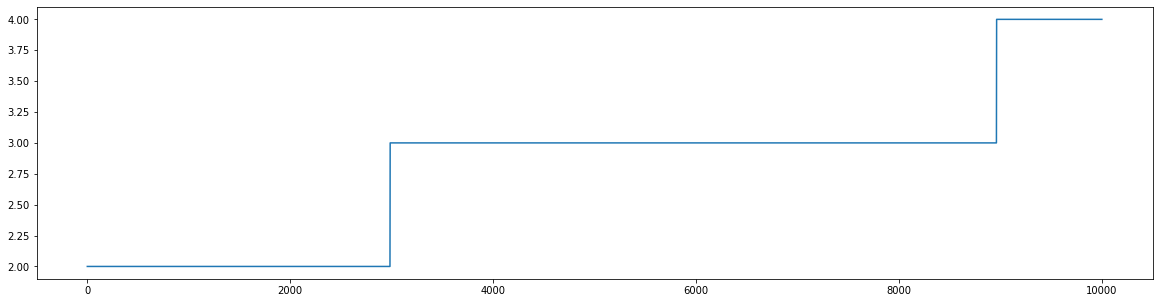

In [42]:
plt.figure()
plt.plot(predictions[15000:25000])
plt.legend(legend)
plt.figure()
plt.plot(predicted_labels[15000:25000])
plt.figure()
plt.plot(test_labels[15000:25000])

In [43]:
training_analysis = model.predict(train)

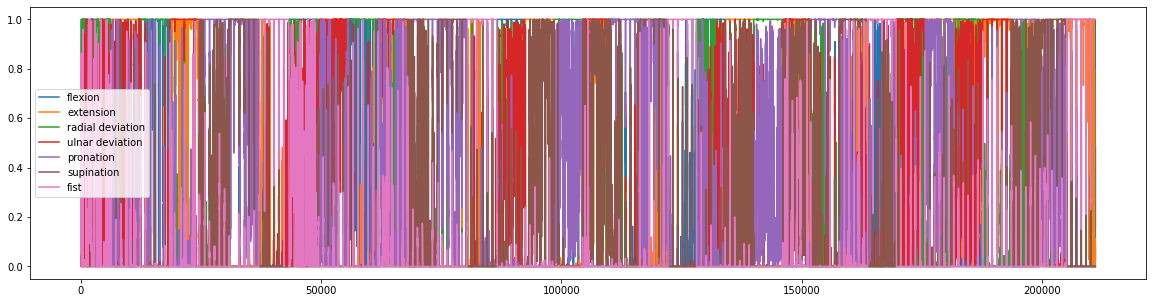

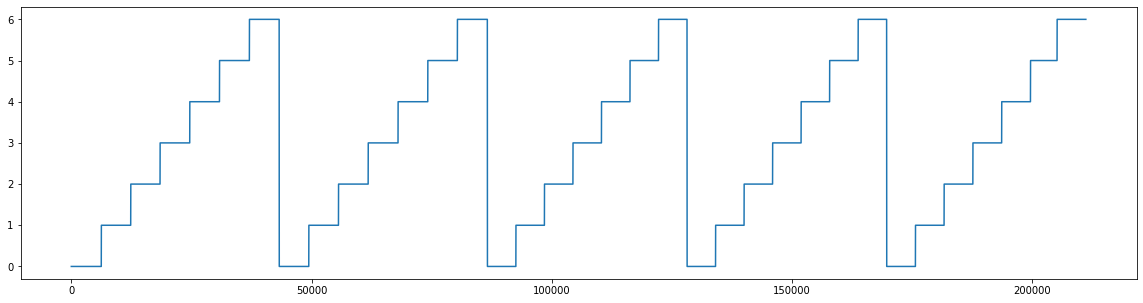

In [44]:
plt.figure()
plt.plot(training_analysis)
plt.legend(legend)
plt.figure()
plt.plot(train_labels)

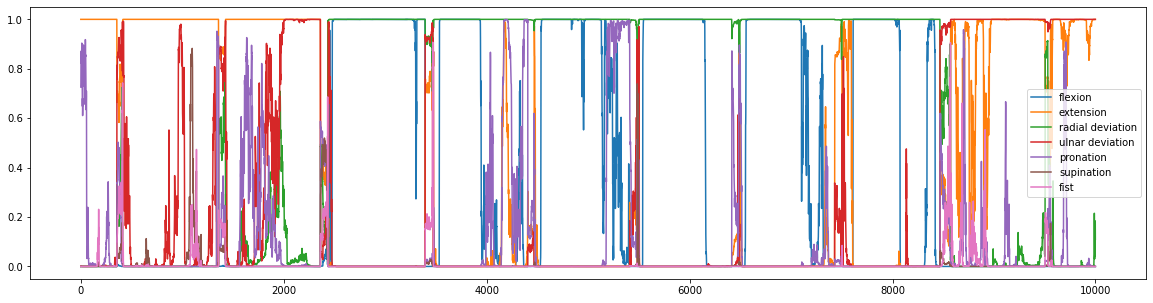

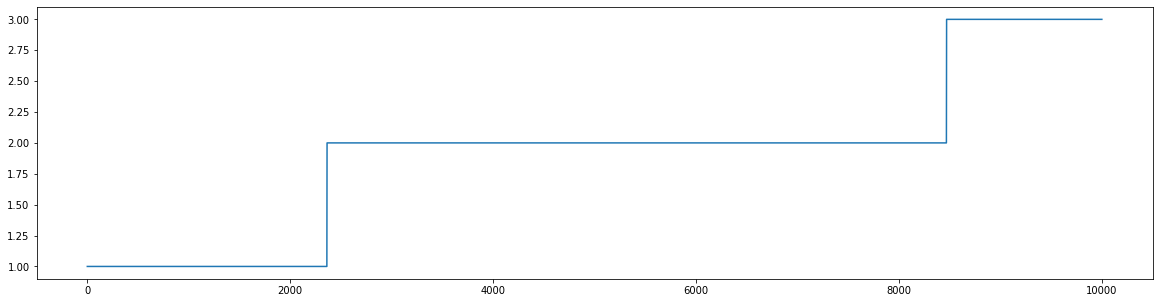

In [45]:
plt.figure()
plt.plot(training_analysis[10000:20000])
plt.legend(legend)
plt.figure()
plt.plot(train_labels[10000:20000])